In [1]:
!pip -q install langchain-core langchain-community langgraph langchain-google-genai duckduckgo-search

In [2]:
import os
from google.colab import userdata

os.environ["GOOGLE_API_KEY"] = userdata.get("GOOGLE_API_KEY")

In [3]:
from langchain_google_genai import ChatGoogleGenerativeAI
llm = ChatGoogleGenerativeAI(model="gemini-2.0-flash")

Tools

In [4]:
def multiply(a: int, b: int) -> int:
  """Multiply a and b.

  Args:
      a: first int
      b: second int
  """
  return a*b

def add(a: int, b: int) -> int:
  """Adds a and b.

  Args:
      a: first int
      b: second int
  """
  return a+b

def divide(a: int, b: int) -> float:
  """Divide a and b.

  Args:
      a: first int
      b: second int
  """
  return a/b

In [5]:
from langchain_community.tools import DuckDuckGoSearchRun
search = DuckDuckGoSearchRun()
search.invoke("How old is Donald Trump?")

"Donald Trump's physical health, including coronary artery disease and a history of severe Covid-19, has raised red flags. ... which would end on January 20, 2029, when he will be 82 years old. Donald Trump's health under scrutiny. Donald Trump's physical health has long been a subject of public scrutiny, and a 2018 physical revealed that he ... How old is Donald Trump? Trump was born on June 14, 1946. On the day of his inauguration, he will be 78 years, 7 months, 6 days, excluding Jan. 20, according to TimeandDate's age calculator. How old is Donald Trump? Trump is 78, the same age Biden when we was sworn in 2021. But, Trump has a June 14 birthday, making him a few months older than Biden was he was sworn in. In a rare speechless moment Sunday, Donald Trump stepped back from the microphone as his Las Vegas supporters spontaneously broke into a disjointed rendition of the world's most recognizable song. How old is Donald Trump? Trump, 78, was born June 14, 1946. He became the 45th pres

In [6]:
tools = [add, multiply, divide, search]
llm_with_tools = llm.bind_tools(tools)

In [7]:
from langgraph.graph import MessagesState
from langchain_core.messages import HumanMessage, SystemMessage

sys_msg = SystemMessage(content="You are a helpful assistant tasked with using search and performing arithmetic on a set of inputs.")

Nodes

In [8]:
def reasoner(state: MessagesState):
  return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}

Building the graph

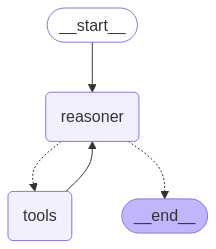

In [9]:
from langgraph.graph import START, StateGraph
from langgraph.prebuilt import tools_condition
from langgraph.prebuilt import ToolNode
from IPython.display import display, Image

#Graph
builder = StateGraph(MessagesState)

#Add nodes
builder.add_node("reasoner", reasoner)
builder.add_node("tools", ToolNode(tools))

#Add edges
builder.add_edge(START, "reasoner")
builder.add_conditional_edges(
    "reasoner",
    tools_condition,
)
builder.add_edge("tools", "reasoner")
react_graph = builder.compile()

#Display the graph
display(Image(react_graph.get_graph(xray=True).draw_mermaid_png()))

In [10]:
messages = [HumanMessage(content="What is 2 times Donuld Trump's age?")]
messages = react_graph.invoke({"messages": messages})

In [11]:
for m in messages['messages']:
  m.pretty_print()

================================ Human Message =================================

What is 2 times Donuld Trump's age?
================================== Ai Message ==================================
Tool Calls:
  duckduckgo_search (a3596bd2-27c9-40e2-a7c0-0ef19e59016a)
 Call ID: a3596bd2-27c9-40e2-a7c0-0ef19e59016a
  Args:
    query: Donald Trump age
================================= Tool Message =================================
Name: duckduckgo_search

How old is Donald Trump? Trump is 78, the same age Biden when we was sworn in 2021. But, Trump has a June 14 birthday, making him a few months older than Biden was he was sworn in. Donald Trump (born June 14, 1946, New York, New York, U.S.) is the 45th and 47th president of the United States (2017-21; 2025- ). Following his inauguration on January 20, 2025, Trump became only the second president to serve two nonconsecutive terms, the first being Grover Cleveland (1885-89; 1893-97). In January 2025, upon his sentencing without punishmen

In [12]:
!pip -q install yahoo-finance

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.8/144.8 kB 4.6 MB/s eta 0:00:00


In [13]:
import yfinance as yf

def get_stock_price(ticker: str) -> float:
  """Gets a stock price from Yahoo Finance.

  Args:
      ticker: ticker str
  """
  stock = yf.Ticker(ticker)
  return stock.info['previousClose']

In [16]:
get_stock_price("AAPL")

238.03

In [17]:
#Node
def reasoner(state):
  query = state["query"]
  messages = state["messages"]
  #System message
  sys_msg = SystemMessage(content="You are a helpful assistant tasked with using search, the yahoo finance tool and performing arithmetic on a set of inputs.")
  #Human message
  message = HumanMessage(content=query)
  messages.append(message)
  result = [llm_with_tools.invoke([sys_msg] + messages)]
  return {"messages": result}

In [18]:
tools = [add, multiply, divide, search, get_stock_price]
llm = ChatGoogleGenerativeAI(model="gemini-2.0-flash")
llm_with_tools = llm.bind_tools(tools)

In [19]:
tools[4]

<function __main__.get_stock_price(ticker: str) -> float>

In [20]:
from typing import Annotated, TypedDict
import operator
from langchain_core.messages import AnyMessage
from langgraph.graph.message import add_messages

class GraphState(TypedDict):
  """State of the graph."""
  query: str
  finance: str
  final_answer: str
  messages: Annotated[list[AnyMessage], operator.add]

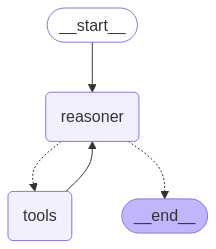

In [21]:
from langgraph.graph import START, StateGraph
from langgraph.prebuilt import tools_condition
from langgraph.prebuilt import ToolNode

#Graph
workflow = StateGraph(GraphState)

#Add Nodes
workflow.add_node("reasoner", reasoner)
workflow.add_node("tools", ToolNode(tools))

#Add Edges
workflow.add_edge(START, "reasoner")
workflow.add_conditional_edges(
    "reasoner",
    tools_condition,
)
workflow.add_edge("tools", "reasoner")
react_graph = workflow.compile()

#Show
display(Image(react_graph.get_graph(xray=True).draw_mermaid_png()))

In [22]:
response = react_graph.invoke({"query": "What is 2 times Brad Pitt's age?", "messages": []})

In [23]:
response['messages'][-1].pretty_print()

================================== Ai Message ==================================

2 times Brad Pitt's age is 120.


In [24]:
response = react_graph.invoke({"query": "What is the stock price of Apple?", "messages": []})

In [25]:
for m in response['messages']:
  m.pretty_print()

================================ Human Message =================================

What is the stock price of Apple?
================================== Ai Message ==================================
Tool Calls:
  get_stock_price (0e250b89-b126-437f-bb4a-da47a8698d30)
 Call ID: 0e250b89-b126-437f-bb4a-da47a8698d30
  Args:
    ticker: AAPL
================================= Tool Message =================================
Name: get_stock_price

238.03
================================ Human Message =================================

What is the stock price of Apple?
================================== Ai Message ==================================

The stock price of Apple is 238.03.


In [26]:
response = react_graph.invoke({"query": "What is the stock price of the company that Jensong Huang is CEO of?", "messages": []})

In [27]:
for m in response['messages']:
  m.pretty_print()

================================ Human Message =================================

What is the stock price of the company that Jensong Huang is CEO of?
================================== Ai Message ==================================
Tool Calls:
  duckduckgo_search (3fa6daad-a0c5-4e7b-ac06-258cb3eddd63)
 Call ID: 3fa6daad-a0c5-4e7b-ac06-258cb3eddd63
  Args:
    query: who is the ceo of nvidia
================================= Tool Message =================================
Name: duckduckgo_search

Jensen Huang (born February 17, 1963, Tainan, Taiwan) is a Taiwanese-born American entrepreneur who cofounded the American semiconductor company NVIDIA Corporation.Under Huang's leadership, NVIDIA has become one of the leading providers of graphics processing units (GPUs) and has taken center stage in the current artificial intelligence (AI) boom. ... Jensen Huang cofounded graphics-chip maker Nvidia in 1993 and has served as its CEO and president ever since. Huang owns approximately 3% of Nvidi

In [28]:
response = react_graph.invoke({"query": "What is the stock price of the company that Jensong Huang is the CEO of if price doubles?"})

In [31]:
for m in response['messages']:
  m.pretty_print()

================================ Human Message =================================

What is the stock price of the company that Jensong Huang is the CEO of if price doubles?
================================== Ai Message ==================================
Tool Calls:
  get_stock_price (9c76df8f-e7a2-4e9e-9b3f-7a0bdd35eab0)
 Call ID: 9c76df8f-e7a2-4e9e-9b3f-7a0bdd35eab0
  Args:
    ticker: NVDA
================================= Tool Message =================================
Name: get_stock_price

114.06
================================ Human Message =================================

What is the stock price of the company that Jensong Huang is the CEO of if price doubles?
================================== Ai Message ==================================
Tool Calls:
  multiply (63b22793-c3a2-4471-b06c-34762969addf)
 Call ID: 63b22793-c3a2-4471-b06c-34762969addf
  Args:
    a: 114.0
    b: 2.0
================================= Tool Message =================================
Name: multiply

228
